In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

import torch_geometric.nn as Gnn
import torch_geometric.data as Gdata
from torch.utils.data import DataLoader, Dataset, random_split

import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
from sklearn.preprocessing import normalize
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Read Data
endocrine_cols = ['α cell', 'β cell' ,'δ cell', 'γ cell', 'epsilon cell']
immune_cols = ['B cell', 'T cell', 'Macrophage', 'Other immune cell']
vascular_cols = ['EC','Pericyte']
miscellaneous = ['miscellaneous']
celltype_cols = endocrine_cols + immune_cols + vascular_cols + miscellaneous
loc_cols = ['XMin', 'XMax', 'YMin', 'YMax']
mid_cols = ['XMid', 'YMid']
label_col = ['T2D_label']

ND_DONORS = ['AFES372', 'ACHM315', 'AFFN281', 'AFG1440', 'AGBA390', 'ABI2259']
T2D_DONORS = ['AEDN413', 'AEJR177', 'ADLE098', 'ABHQ115', 'ABIC495', 'ABIQ254', 'ADIX484', 'AFCM451', 'ACIA085', 'ADBI307']

label_dict = {}
for donor in ND_DONORS:
    label_dict[donor]='ND'
for donor in T2D_DONORS:
    label_dict[donor]='T2D'

def get_type(x, feature_columns=celltype_cols):
    for i in feature_columns:
        if x[i] == 1:
            return i
    return 'NoneType'
 
def preprocess(trg_csv_path:str):
    raw_DF = pd.read_csv(trg_csv_path)
    raw_DF.rename(columns={'ɛ cell': 'epsilon cell'}, inplace=True)
    raw_DF['miscellaneous'] = raw_DF['Arg1 Positive Classification'] | raw_DF['Ki67 Positive Classification']
    raw_DF['T2D_label'] = raw_DF['Group']=='T2D'

    raw_DF['CellType'] = raw_DF.apply(lambda x: get_type(x), axis=1)
    raw_DF['IsletID'] = raw_DF.apply(lambda x: x['Donor'] + '-' + str(x['Islet']), axis=1)
    for islet, islet_indices in raw_DF.groupby('IsletID').groups.items():
        raw_DF.loc[islet_indices, ['XMin', 'XMax']] -= raw_DF.loc[islet_indices, 'XMin'].min()
        raw_DF.loc[islet_indices, ['YMin', 'YMax']] -= raw_DF.loc[islet_indices, 'YMin'].min()

    raw_DF['XMid'] = (raw_DF['XMin'] + raw_DF['XMax'])/2.0
    raw_DF['YMid'] = (raw_DF['YMin'] + raw_DF['YMax'])/2.0

    raw_DF[['IsletID', 'CellType']+mid_cols+celltype_cols]
    return raw_DF

# raw_DF = preprocess(trg_csv_path='/mlodata1/sfan/CFIDF/data/Cell-ID_by-islet.csv')

In [3]:
# FEATURE_COLS = celltype_cols + ['center_distance']

def get_category(raw_DF, 
                 feature_cols = celltype_cols, 
                 save_root=None):
    ## Islet-wise info as a Single Graph.
    donors = set(raw_DF['Donor'].values)
    Islet_info = []

    for don in tqdm(donors):
        donor_DF = raw_DF[raw_DF['Donor']==don]
        
        # -------- Islet Level -------- #
        num_islets = 0
        islets = set(donor_DF['Islet'].values)
        for islet in islets:
            islet_DF = donor_DF[donor_DF['Islet']==islet]
            trg_islet_dict = OrderedDict()
            trg_islet_dict['IsletID'] = don+'-'+str(islet)
            trg_islet_dict['label'] = donor_DF['T2D_label'].values[0]

            XMID = np.mean(islet_DF['XMid'].values)
            YMID = np.mean(islet_DF['YMid'].values)

            trg_islet_dict['center_x'] = XMID
            trg_islet_dict['center_y'] = YMID

            DY = np.array(islet_DF['YMid'].values)-YMID
            DX = np.array(islet_DF['XMid'].values)-XMID
            # print(DX.shape, DY.shape)
            dists=np.linalg.norm(np.stack([DX, DY]).T, axis=1)
            dist_u = np.mean(dists)
            dist_sigma = np.std(dists)

            islet_DF['center_distance'] = (dists - dist_u)/(dist_sigma)

            dist = ['center_distance']
            trg_islet_dict['features'] = islet_DF[loc_cols+dist+feature_cols+['IsletID']].reset_index(drop=True)
            Islet_info.append(trg_islet_dict)
            
            if save_root is not None:
                if not os.path.exists(save_root):
                    os.makedirs(save_root, exist_ok=True)
                islet_save_file = don+'-islet-'+str(islet)+donor_DF['Group'].values[0]+'.csv'
                islet_save_path = os.path.join(save_root, islet_save_file)
                islet_DF.to_csv(islet_save_path)
    return Islet_info

In [4]:
## Step 1: Construct Graph Structure
class GraphDataset(Gdata.Dataset):
    def __init__(self, 
                 data_info, 
                 feature_cols, 
                 loc_cols, 
                 weighted=False):
        super().__init__()
        self.weighted = weighted
        # self.num_classes = 2
        self.sizes = []        
        self.data = self._get_data(data_info, feature_cols, loc_cols)
    
    def _get_data(self, data_info, feature_cols, loc_cols, n_edge=None):
        data_entries = []
        
        for idx, data_entry in enumerate(tqdm(data_info)):
            label = torch.tensor(int(data_entry['label'])).long()
            features = torch.from_numpy(np.asarray(data_entry['features'][feature_cols].values)).float()
            
            loc = data_entry['features'][loc_cols].values
            x = np.mean(loc[:, 0:2], axis=-1)
            y = np.mean(loc[:, 2:4], axis=-1)
            
            center = np.stack((x, y)).T
            pos = center

            n = len(data_entry['features'])
            logits = np.linalg.norm(center.reshape(1, n, 2) - center.reshape(n, 1, 2), axis=2)

            if not self.weighted:
                n_edge = min(8, n) * n
                threshold = np.sort(logits.reshape(-1))[min(n_edge+n, len(logits.flatten())-1)]
                adj = (logits <= threshold).astype(float) - np.eye(n)
                edge_index = torch.tensor(np.array(list(adj.nonzero())))
                data = Gdata.Data(x=features, edge_index=edge_index, y=label, loc=pos)
                
            else:
                edge_weights_matrix = np.log2(1.0/(0.005+normalize(logits))) # 0.005: smoothing
                n_edge = min(20, n//5) * n
                threshold = np.sort(logits.reshape(-1))[min(n_edge+n, len(logits.flatten())-1)]
                adj = (logits <= threshold).astype(float) - np.eye(n)
                edge_index = torch.tensor(np.array(list(adj.nonzero())))

                # Edge Weights
                edge_weights = np.zeros(edge_index.shape[1])
                for idx, x in enumerate(edge_index.T):
                    edge_weights[idx] = logits[x[0].item(), x[1].item()]
                edge_weights = torch.tensor(edge_weights, dtype=torch.float)
                data = Gdata.Data(x=features, edge_index=edge_index, y=label, loc=pos, edge_weights=edge_weights)
            
            m = n // 3
            idx_list = list(range(n))
            random.shuffle(idx_list)
            train_ids = idx_list[:m]
            val_ids = idx_list[m:2*m]
            test_ids = idx_list[-m:]
            data.train_mask = torch.zeros(n).to(dtype=torch.bool)
            data.train_mask[train_ids] = True
            data.val_mask = torch.zeros(n).to(dtype=torch.bool)
            data.val_mask[val_ids] = True
            data.test_mask = torch.zeros(n).to(dtype=torch.bool)
            data.test_mask[test_ids] = True
            data.ID = data_entry['IsletID']
            data_entries.append(data)
            self.sizes.append(n)
        return data_entries
            
    def len(self):
        return len(self.data)
    
    def get(self, idx):
        return self.data[idx]

# ## Get weighted Graph for each islet (681 graphs, ~22s for construction)
# weighted_islet_graph_set = GraphDataset(Islet_info, FEATURE_COLS, loc_cols, weighted=True)

In [5]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from networkx.algorithms.community.centrality import girvan_newman

# compute the best partition with Louvain Modularity Algorithm #
def louvain_community_detection(G, G_pos=None, title=None, weighted=True, fig_dir_path=None, cmap_string='Dark2', edge_coloring=True, show=True):
  partition = community_louvain.best_partition(G, weight='edge_weights', random_state=42, randomize=False)
  if show:
    print(f'#Communities: {len(set(partition.values()))}')
    plt.figure(figsize=(16, 12))

    # draw the graph
    if G_pos is None:
      pos = nx.spring_layout(G)
    else:
      pos = G_pos
    # color the nodes according to their partition
    cmap = cm.get_cmap(cmap_string, max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                          cmap=cmap, node_color=list(partition.values()))
    if edge_coloring:
      weights_labels = np.array(list(nx.get_edge_attributes(G,'edge_weights').values()), dtype=float)
      weights = 2*np.log2(weights_labels/np.max(weights_labels))
      nx.draw_networkx_edges(G, pos, alpha=0.7, width=weights, edge_cmap=cmap, edge_color=[list(partition.values())[u] for u, v in G.edges])
    else:
      nx.draw_networkx_edges(G, pos, alpha=0.5)
    if title is not None:
      plt.title(title)
    ax = plt.gca()
    plt.text(0.1, 0.95, f'#Communities: {len(set(partition.values()))}', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=15)
    if fig_dir_path is not None:
      if not os.path.exists(fig_dir_path):
          os.makedirs(fig_dir_path)
      plt.savefig(os.path.join(fig_dir_path, f'{title}.png'))

  return partition

def Graphset_Partition(trg_csv_path, 
                       celltype_cols, 
                       loc_cols=loc_cols, 
                       weighted=True, 
                       preview=3, 
                       data_dir=None, 
                       fig_dir=None,
                       edge_coloring=True, 
                       cmap_string='Dark2'):
    raw_DF = preprocess(trg_csv_path=trg_csv_path)
    islet_root = os.path.join(data_dir, 'islet_data')
    islet_info = get_category(raw_DF=raw_DF, feature_cols=celltype_cols, save_root=islet_root)
    graph_set = GraphDataset(islet_info, celltype_cols+['center_distance'], loc_cols, weighted=weighted)
    for i in tqdm(range(len(graph_set))):
        # print('\n=====================================')
        G = to_networkx(graph_set[i], to_undirected=True, remove_self_loops=True, edge_attrs=['edge_weights'])
        G_pos = graph_set[i].loc
        partition = louvain_community_detection(G, G_pos, title=graph_set[i].ID, fig_dir_path=fig_dir, weighted=True, edge_coloring=True, cmap_string='Dark2', show=(i < preview))
        graph_set[i].communities = np.array(partition.values())
        islet_info[i]['features']['community_idx']=list(partition.values())
    return raw_DF, islet_info, graph_set

  0%|          | 0/681 [00:00<?, ?it/s]

#Communities: 4


  0%|          | 1/681 [00:00<05:45,  1.97it/s]

#Communities: 6


  0%|          | 2/681 [00:01<06:08,  1.84it/s]

#Communities: 4


100%|██████████| 681/681 [00:29<00:00, 23.42it/s]


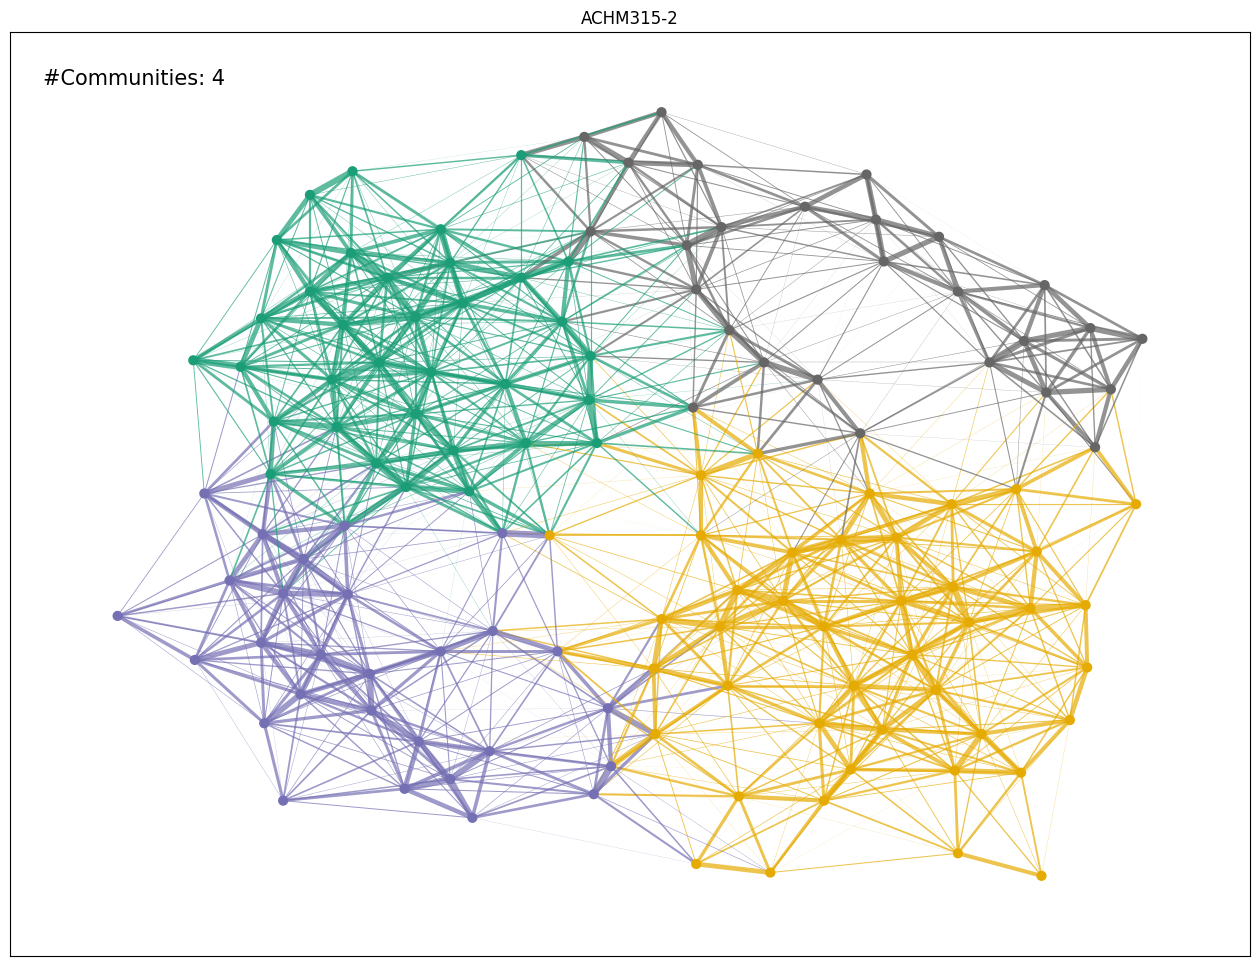

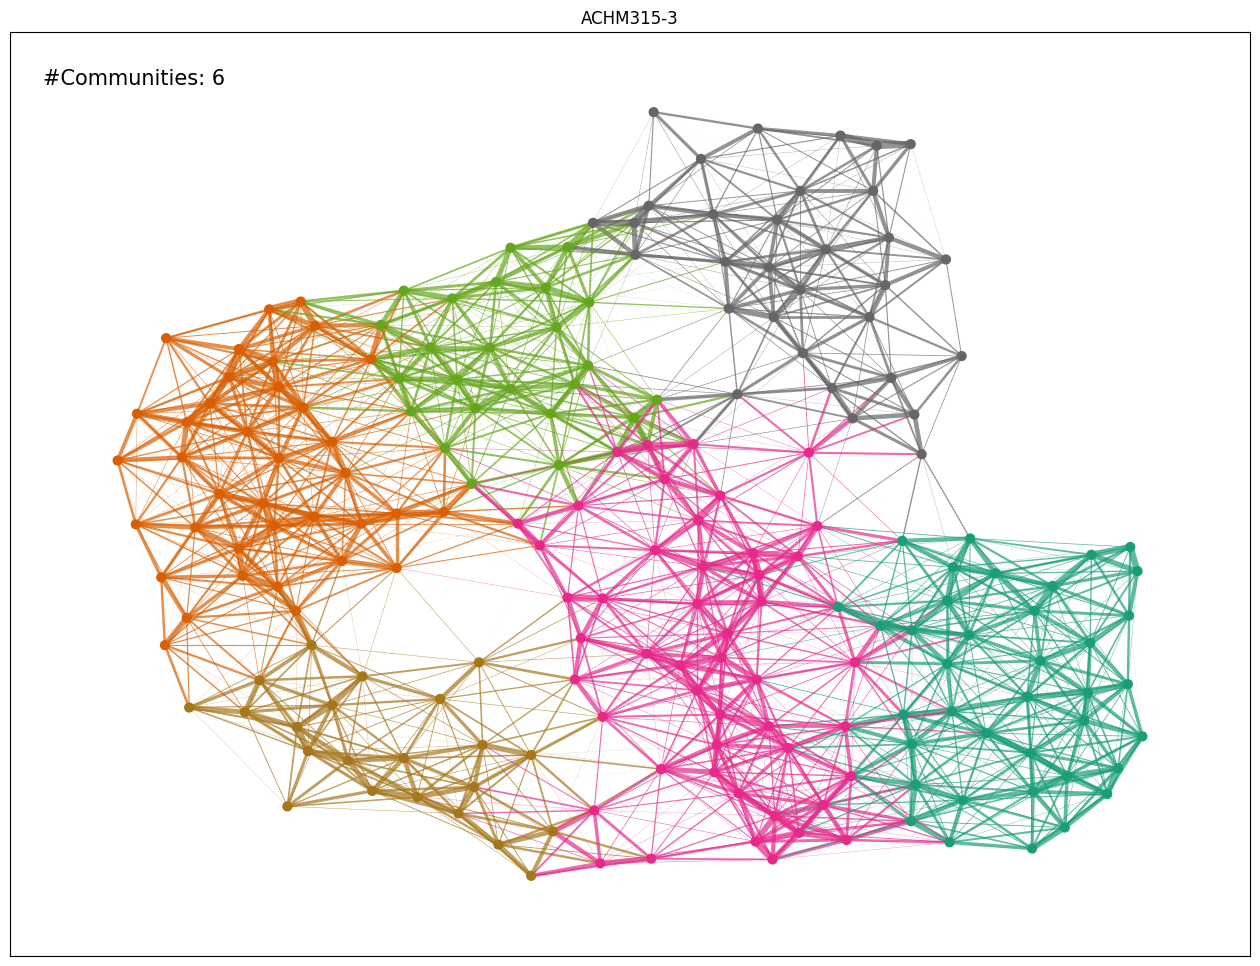

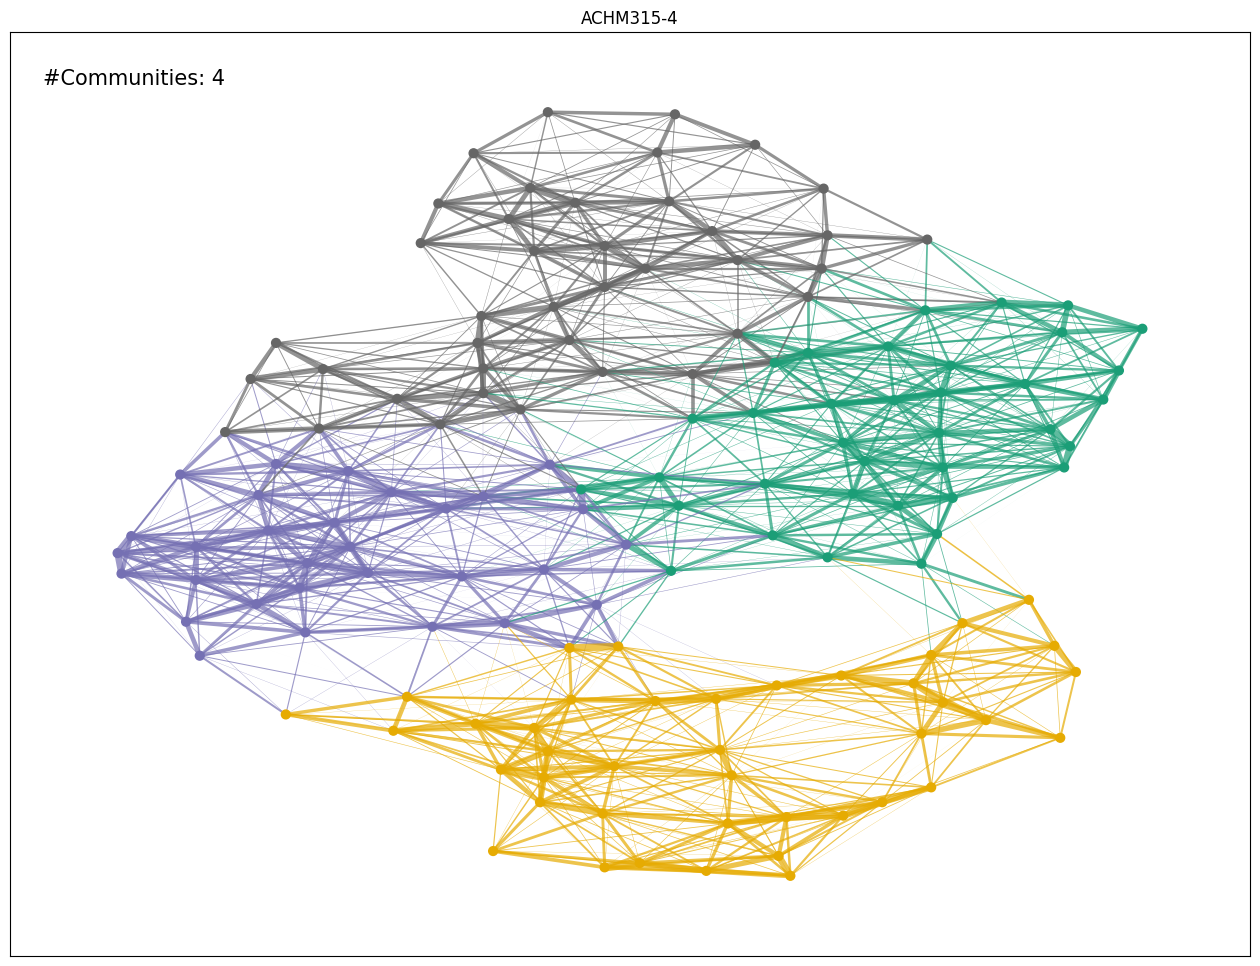

In [6]:
raw_DF, islet_info, graph_set = Graphset_Partition(trg_csv_path='/mlodata1/sfan/CFIDF/data/Cell-ID_by-islet.csv', 
                                                    celltype_cols=celltype_cols,
                                                    weighted=True,
                                                    data_dir='/mlodata1/sfan/CFIDF/data',
                                                    fig_dir='/mlodata1/sfan/CFIDF/figs',
                                                    preview=3) ### ~10min to run the partition ###

## Enrichment Analysis

In [10]:
type_cols = [x for x in raw_DF['CellType'].unique() if x !='NoneType']
# type_cols
# => ['EC', 'T cell', 'β cell', 'α cell', 'γ cell', 'Pericyte', 'miscellaneous', 'δ cell', 'epsilon cell', 'Other immune cell', 'Macrophage'] 


In [11]:
def get_freq(x,y):
    if y==0:
        return list(np.zeros_like(x))
    return list(x/y)

def CFIDF(num_celltype_per_communiy, 
          num_cell_per_communiy, 
          sum_celltype_all_communiy, 
          sum_cell_all_communiy, ):
    CF = np.array([get_freq(x, y) for x, y in zip(num_celltype_per_communiy,num_cell_per_communiy)], dtype=float)
    IDF = np.log(np.array(sum_cell_all_communiy/sum_celltype_all_communiy, dtype=float))
    CFIDF_score = CF*IDF
    return CFIDF_score

def get_CFIDF(islet_info, type_cols):
    community_list = []

    for i in range(len(islet_info)):
        communities = islet_info[i]['features'].groupby(by='community_idx')
        for key in set(islet_info[i]['features']['community_idx'].values):
            community_name = islet_info[i]['IsletID']+'-'+str(key)
            community_celltype_series = communities.get_group(key)[type_cols].sum()
            community_celltype_series['community_name']=community_name
            community_celltype_series['Donor']=islet_info[i]['IsletID'].split('-')[0]
            community_list.append(community_celltype_series)
    
    community_DF = pd.concat(community_list, axis=1).transpose()
    community_DF['IsletID'] = ['-'.join(x.split('-')[:2]) for x in community_DF['community_name']]
    community_DF['community_ID'] = [x.split('-')[-1] for x in community_DF['community_name']]
    community_DF.rename(columns={'ɛ cell': 'epsilon cell'}, inplace=True)
    
    num_celltype_per_communiy = community_DF[type_cols].values
    num_cell_per_communiy = community_DF[type_cols].sum(axis=1).values
    sum_celltype_all_communiy = community_DF[type_cols].values.sum(axis=0)
    sum_cell_all_communiy = community_DF[type_cols].values.sum()
    cfidf_islet_score = CFIDF(num_celltype_per_communiy, 
                            num_cell_per_communiy, 
                            sum_celltype_all_communiy, 
                            sum_cell_all_communiy, )
    
    return community_DF, cfidf_islet_score


In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


## Elbow filtering: for selecting the proper num_clusters (K) for k_means clustering
def Elbow_filter(X, y=None, k_start=1, k_end=20, metric='distortion'):
    tag_model = KMeans(init='k-means++')
    visualizer = KElbowVisualizer(tag_model, k=range(k_start, k_end+1), metric=metric, timings=False)

    visualizer.fit(X)
    visualizer.show()
    
def kmeans_elbow_analysis(CFIDF_score, k_end=10):
    Elbow_filter(X=CFIDF_score, k_start=1, k_end=k_end, metric='distortion')
    Elbow_filter(X=CFIDF_score, k_start=2, k_end=k_end, metric='calinski_harabasz')
    Elbow_filter(X=CFIDF_score, k_start=2, k_end=k_end, metric = 'silhouette')
    
def kmeans_centroids(n_clusters, scores):
    km = KMeans(n_clusters=n_clusters, random_state=0)
    community_labels = km.fit_predict(scores)
    community_centers = list(km.cluster_centers_)
    return community_labels, community_centers

In [13]:
community_DF, cfidf_islet_score = get_CFIDF(islet_info, type_cols)

In [14]:
community_DF.head()

,EC,T cell,β cell,α cell,γ cell,Pericyte,miscellaneous,δ cell,epsilon cell,Other immune cell,Macrophage,community_name,Donor,IsletID,community_ID
0,1,0,20,9,0,0,3,0,0,0,1,ACHM315-2-0,ACHM315,ACHM315-2,0
1,1,0,5,14,0,1,0,0,0,0,2,ACHM315-2-1,ACHM315,ACHM315-2,1
2,4,0,22,6,0,1,4,1,0,0,2,ACHM315-2-2,ACHM315,ACHM315-2,2
3,0,0,7,7,0,0,0,0,0,0,5,ACHM315-2-3,ACHM315,ACHM315-2,3
4,3,0,8,12,1,2,1,2,0,0,2,ACHM315-3-0,ACHM315,ACHM315-3,0


In [ ]:
kmeans_elbow_analysis(cfidf_islet_score, k_end=10)

In [16]:
k_best = 6

community_labels, niche_clusters = kmeans_centroids(n_clusters=k_best, scores=cfidf_islet_score)
fc = pd.DataFrame(niche_clusters, columns=type_cols)
fc.rename(columns={'ɛ cell': 'epsilon cell'}, inplace=True)



In [17]:
def enrichment_analysis(n_clusters, scores, type_cols):
    community_labels, niche_clusters = kmeans_centroids(n_clusters=n_clusters, scores=scores)
    fc = pd.DataFrame(niche_clusters, columns=type_cols)
    fc.rename(columns={'ɛ cell': 'epsilon cell'}, inplace=True)
    if 'epsilon cell' not in type_cols:
        type_cols[type_cols.index('ɛ cell')]='epsilon cell'
    mean_freq = np.mean(fc.loc[[i for i in range(n_clusters)], type_cols].mean().values)

    g = sns.clustermap(fc.loc[[i for i in range(n_clusters)], type_cols], center=mean_freq, cmap="vlag", row_cluster=False,
                    dendrogram_ratio=(.1, .2),
                    cbar_pos=(.02, .32, .03, .2),
                    linewidths=.75, figsize=(20, 10))

    g.ax_row_dendrogram.remove()
    plt.title(f'Louvian Community(k={n_clusters})', fontsize=15)

    

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

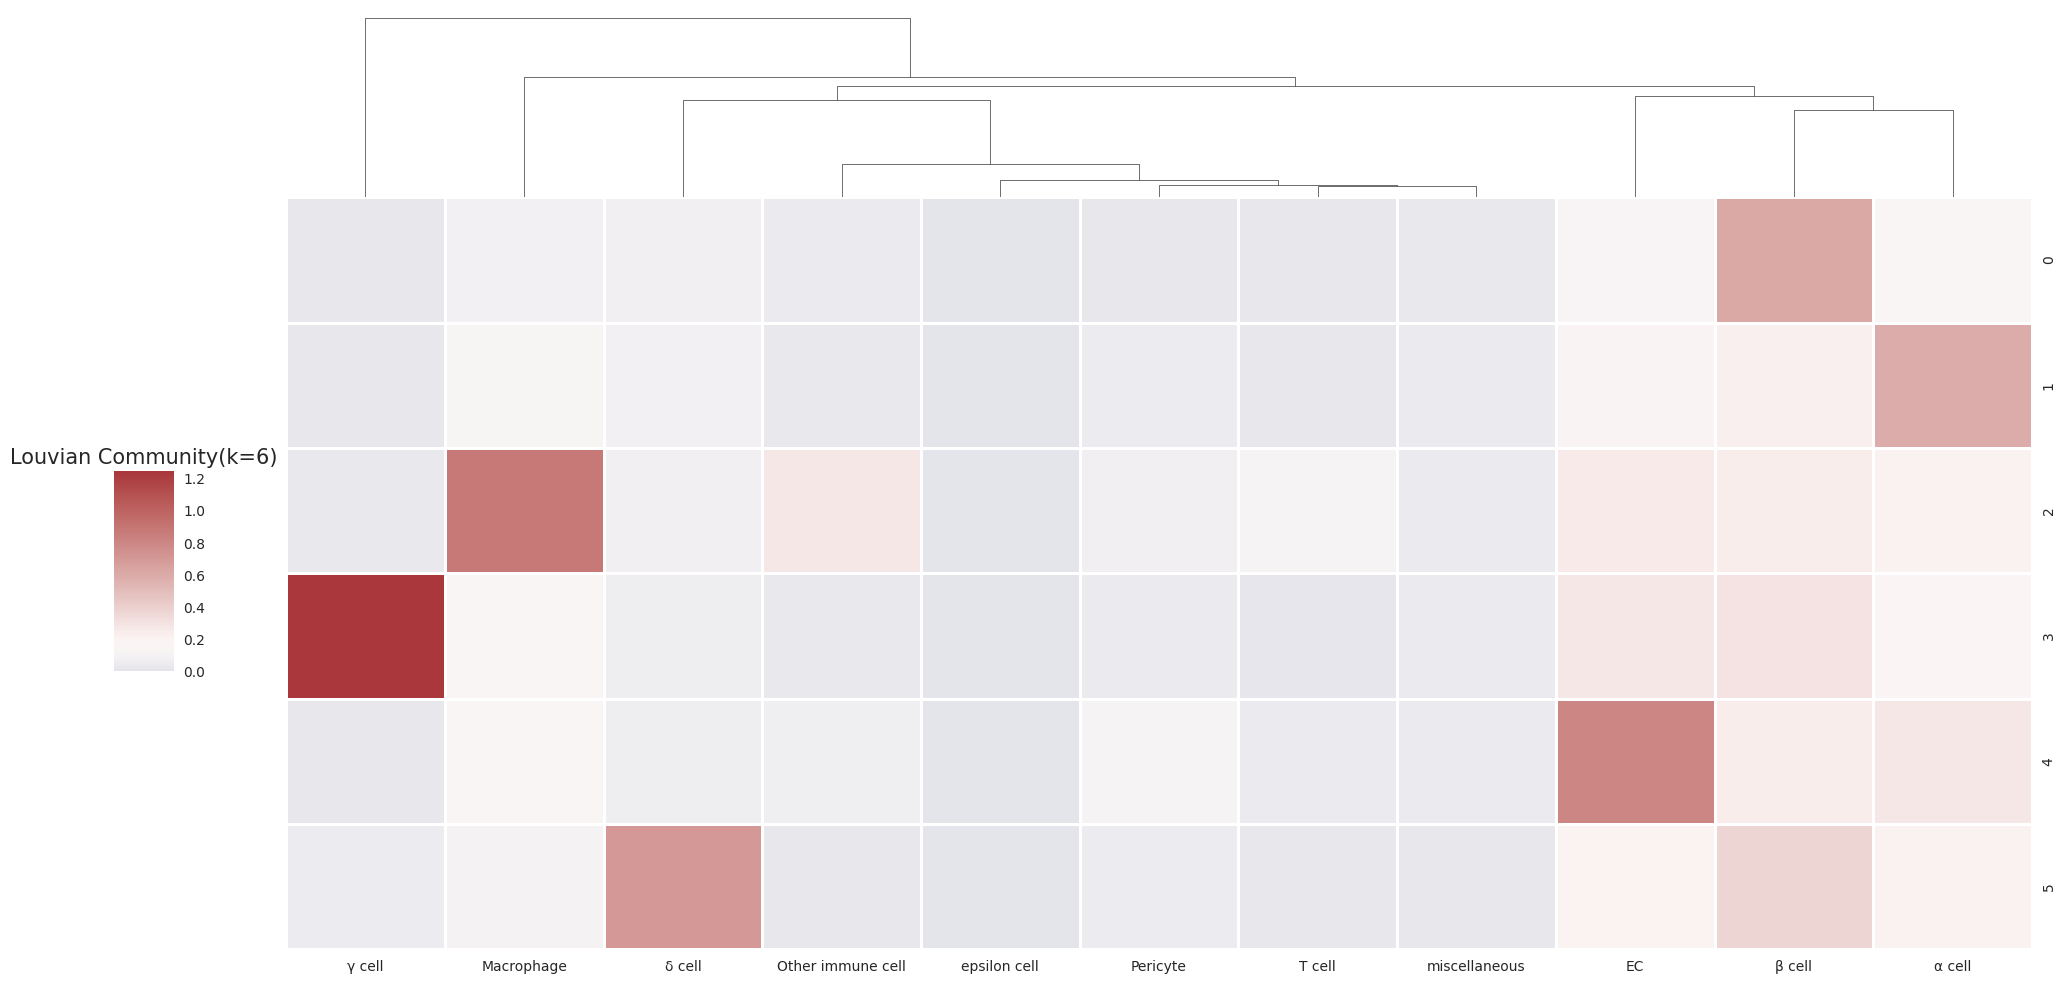

In [18]:
enrichment_analysis(n_clusters=k_best, scores=cfidf_islet_score, type_cols=type_cols)


In [19]:
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi
import matplotlib.patches as mpatches

In [20]:
def get_color(i,scatter_palette = sns.color_palette('bright')):
    if int(i)<10:
        return scatter_palette[int(i)]
    return 'black'
        
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    adapted from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647 3.18.2019
    
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def plot_voronoi(points,colors,invert_y = True,edge_color = 'facecolor',line_width = .1,alpha = 1,size_max=np.inf):

    if invert_y:
        points[:,1] = max(points[:,1])-points[:,1]
    vor = Voronoi(points)

    regions, vertices = voronoi_finite_polygons_2d(vor)

    pts = MultiPoint([Point(i) for i in points])
    mask = pts.convex_hull
    new_vertices = []
    if type(alpha)!=list:
        alpha = [alpha]*len(points)
    areas = []
    for i,(region,alph) in enumerate(zip(regions,alpha)):
        polygon = vertices[region]
        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
        areas+=[p.area]
        if p.area <size_max:
            poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
            new_vertices.append(poly)
            if edge_color == 'facecolor':
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  colors[i],linewidth = line_width , facecolor = colors[i])
            else:
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  edge_color,linewidth = line_width, facecolor = colors[i])
        # else:

        #     plt.scatter(np.mean(p.boundary.xy[0]),np.mean(p.boundary.xy[1]),c = colors[i])
    return areas
def draw_voronoi_scatter(spot,c,voronoi_palette = sns.color_palette('rocket_r'),scatter_palette = sns.color_palette('bright'),X = 'X:X', Y = 'Y:Y',voronoi_hue = 'neighborhood10',scatter_hue = 'ClusterName',
        figsize = (8,8),
         voronoi_kwargs = {},
         scatter_kwargs = {}, fname='', title=None):

    '''
    plot voronoi of a region and overlay the location of specific cell types onto this
    
    spot:  cells that are used for voronoi diagram
    c:  cells that are plotted over voronoi
    palette:  color palette used for coloring neighborhoods
    X/Y:  column name used for X/Y locations
    hue:  column name used for neighborhood allocation
    figsize:  size of figure
    voronoi_kwargs:  arguments passed to plot_vornoi function
    scatter_kwargs:  arguments passed to plt.scatter()

    returns sizes of each voronoi to make it easier to pick a size_max argument if necessary
    '''
    if len(c)>0:
        neigh_alpha = .3
    else:
        neigh_alpha = .3
        
    voronoi_kwargs = {**{'alpha':neigh_alpha},**voronoi_kwargs}
    scatter_kwargs = {**{'s':50,'alpha':1,'marker':'.'},**scatter_kwargs}
    
    plt.figure(figsize = figsize)
    ax = plt.gca()
    colors  = [voronoi_palette[i] for i in spot[voronoi_hue]]
    a = plot_voronoi(spot[[X,Y]].values,
                 colors,#[{0:'white',1:'red',2:'purple'}[i] for i in spot['color']],
                     edge_color = 'black', line_width = .1,
                 **voronoi_kwargs)
    
    if len(c)>0:
        if 'c' not in scatter_kwargs:
            colors  = [get_color(i) for i in c[scatter_hue]]
            scatter_kwargs['c'] = colors
            
        plt.scatter(x = c[X],y = (max(spot[Y])-c[Y].values),
                  **scatter_kwargs
                   )
    plt.axis('on')
    
    legend1 = plt.legend(handles=[mpatches.Patch(color=voronoi_palette[0], alpha=0.3, label='0'),
                                  mpatches.Patch(color=voronoi_palette[1], alpha=0.3, label='1'),
                                  mpatches.Patch(color=voronoi_palette[2], alpha=0.3, label='2'),
                                  mpatches.Patch(color=voronoi_palette[3], alpha=0.3, label='3'),
                                  mpatches.Patch(color=voronoi_palette[4], alpha=0.3, label='4')
                                 ],
                         title='CN', bbox_to_anchor=(1.20, 0), loc='lower right', frameon=False)
    ax.add_artist(legend1)
    legend2 = plt.legend(handles=[plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[0], label='α cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[1], label='β cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[2], label='δ cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[3], label='γ cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[4], label='epsilon cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[5], label='T cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[6], label='Macrophage')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[7], label='miscellaneous')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[8], label='Other immune cell')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color=scatter_palette[9], label='EC')[0],
                                  plt.plot([],[], marker='o', ms=10, ls='', color='black', label='Pericyte')[0]],
                         title='CT', bbox_to_anchor=(1.35, 1), loc='upper right', frameon=False)
    if title is not None:
        plt.title(title)
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    return a

In [21]:
community_DF['Community_Labels'] = list(community_labels)

Community_Reference = {}

for idx,row in community_DF[['IsletID','community_ID', 'Community_Labels']].iterrows():
    isletID, comID, comLabel = row.values
    if isletID not in Community_Reference.keys():
        Community_Reference[isletID] = OrderedDict()
    Community_Reference[isletID][comID] = comLabel 

In [22]:
def get_celltype(idx, islet_DF):
    if len(islet_DF[type_cols].iloc[idx].values.nonzero()[0])==0:
        return 'NoneType'
    return type_cols[islet_DF[type_cols].iloc[idx].values.nonzero()[0][0]]
    
for islet in tqdm(islet_info):
    islet_id = islet['IsletID']
    islet_DF = islet['features']
    islet_DF.rename(columns={'ɛ cell': 'epsilon cell'}, inplace=True)
    community_label = [Community_Reference[islet_id][str(comID)] for comID in islet_DF['community_idx'].values]
    islet_DF['XMid'] = np.mean(islet_DF[['XMin', 'XMax']], axis=1)
    islet_DF['YMid'] = np.mean(islet_DF[['YMin', 'YMax']], axis=1)
    islet_DF['community_label'] = community_label
    islet_DF['Donor'] = [x.split('-')[0] for x in islet_DF['IsletID']]
    islet_DF['islet-index'] = [x.split('-')[-1] for x in islet_DF['IsletID']]
    islet_DF['celltype'] = [get_celltype(idx, islet_DF) for idx in range(len(islet_DF))]

100%|██████████| 681/681 [01:08<00:00,  9.91it/s]


## voronoi analysis

In [44]:
color_dict = {'α cell': 0, 'β cell': 1, 'δ cell': 2, 'γ cell': 3, 'epsilon cell': 4, 'T cell': 5, 'Macrophage': 6, 'miscellaneous': 7, 'Other immune cell': 8, 'EC': 9, 'Pericyte': 10}


In [47]:
def vplot_cell(islet_entry, cell_type, fig_dir):
    islet_DF = islet_entry['features']
    islet_name = islet_entry['IsletID']
    spot = islet_DF
    cd4s = spot[spot[cell_type]==1]
    if fig_dir is not None:
        save_dir = os.join(fig_dir, f'/Voronoi_Analysis/v_cell_plot/')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.join(save_dir, f'{islet_name+"-"+cell_type}.png')
    _ = draw_voronoi_scatter(spot, cd4s, X='XMid', Y='YMid', voronoi_hue='community_label', scatter_hue='ColorIndex', fname=save_path)


def vplot_islet(islet_entry, fig_dir):
    islet_DF = islet_entry['features']
    islet_name = islet_entry['IsletID']
    spot = islet_DF
    if fig_dir is not None:
        save_dir = os.join(fig_dir, f'/Voronoi_Analysis/v_islet_plot/')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.join(save_dir, f'{islet_name}.png')
    _ = draw_voronoi_scatter(spot, spot, X='XMid', Y='YMid', voronoi_hue='community_label', scatter_hue='ColorIndex', fname=save_path, title=islet_entry['IsletID'])

def vplot_all(islet_info):
    for islet_entry in tqdm(islet_info):
        islet_entry['features'] = islet_entry['features'][islet_entry['features']['celltype']!='NoneType']
        islet_entry['features']['ColorIndex'] = islet_entry['features']['celltype'].apply(lambda x: color_dict[x])
        print('Name:', islet_entry['IsletID'])
        try:
            vplot_islet(islet_entry)
        except:
            continue


In [ ]:
vplot_all(islet_info)